# Trading Places
1. Read in data using Dask __(1 point)__
2. Descriptive Statistics: __(2 points)__
    
    a. In the year 2012, who were the top 10 countries with the most trading partners? What about the bottom 10?
    
    b. Using the designation [here]( https://www.foreign-trade.com/reference/hscode.htm), describe the trade volume of the whole dataset in terms of value and list the five highest value sectors in the entire sample period.

3. Country statistics: __(3 points)__

    a. Calculate the top 10 exports (in terms of value) of our chosen country in 2012.

    b. Calculate the top 10 goods with the highest trade volume for both exports and imports in terms of:
    
        i. Value
    
        ii. Quantity

3. The Gravity Equation Relationship __(4 points)__

    a. Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen country and all the other centroids. You may use either haversine distance with the geographic CRS or use a projected CRS and use the `distance` function of `geopandas`.
    
    b. Using the country we chose in class, create a scatterplot of distance and export volume (quantity and value) in logarithm form.
    
    c. Calculate the correlations between exports and distance for both value and quantity. Interpret the correlations for each of these factors.
    
    d. Using the designation you created in 2.d., for which sectors are exports (quantity) most strongly related to distance for this country?
    
4. Estimation __(6 points)__
    
    a. Create a function called "SSE_1p" that does the following given a scalar input $\beta$:
        1. Subtracts the logarithm of quantity exports from the logarithm of distance times $\beta$.
$$ e = log(E_{ij}) - \beta log(d_{ij}) $$
        2. Squares the error.
        3. Returns the sum of the squared error. 
    b. Plot the function from -1 to +3 with steps of .005, and then find the minimum of the function with the numpy function "argmin." Is it what you expected?
    
    c. Create another function called "SSE_2p" does the same as "SSE_1p" but instead takes a __vector__ as an argument:
 $$ e = log(E_{ij}) - \beta[0] - \beta[1] log(d_{ij})$$
 
     d. Do a grid search with the first parameter range as 1500 to 2500 in steps of 10, and the second parameter range as -1 to +3 in steps of .005 as before. Do it using either `dask` or `multiprocessing`. Comment on how or why the parameter on $log(d_{ij})$ is different than what you found in part 4b.
     
     e. Now check your results using the "econtools" package "reg" function by running OLS with a constant term.
     
     f. Finally, merge in the GDP numbers from the World Bank and do the regression again, except this time the log of each country's GDP as covariates. How did the coefficient on distance change?
     
5. An analyst asks you "for which commodity sectors is distance most important in terms of exporting?" Describe what your economic intuition would say about the answer, and then also map out an analysis strategy for answering their question. As usual, describe: __(4 points)__
    - What data you would need.
    - How you would manipulate the data.
    - What analysis you would run.

In [30]:
import glob
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import json
import dask
import geopandas as gp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt


def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = row
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [2]:
#Each row represents the trade flows from country $i$ to country $j$ for product $k$ in time $t$ 
#in terms of either value or quantity.

# Question 1

In [3]:
products = pd.read_csv("/Users/isaacwerries/Desktop/test/Hw3/product_codes_HS12_V202001.csv")
products = products.rename(columns={"code":"k"})

In [4]:
df = pd.read_csv('/Users/isaacwerries/Desktop/test/Hw3/BACI_HS12_Y2012_V202001.csv.crdownload')

In [5]:
df12 = dd.read_csv('/Users/isaacwerries/Desktop/test/Hw3/BACI_HS12_Y*.csv.crdownload')

In [6]:
df12_names = df12.merge(products)

In [7]:
countries = pd.read_csv("/Users/isaacwerries/Desktop/test/Hw3/country_codes_V202001.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df12_names = df12_names.merge(countries[['i','name_i']])

countries = pd.read_csv("/Users/isaacwerries/Desktop/test/Hw3/country_codes_V202001.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df12_names = df12_names.merge(countries[['j','name_j']])
df12_names.head()

,t,i,j,k,v,q,description,name_i,name_j
0,2012,4,8,610469,2.734000,0.044000,"Trousers, bib and brace overalls, breeches and...",Afghanistan,Albania
1,2012,32,8,170490,22.438000,8.443000,"Sugar confectionery: (excluding chewing gum, i...",Argentina,Albania
2,2012,32,8,300490,166.408111,3.360398,Medicaments: consisting of mixed or unmixed pr...,Argentina,Albania
3,2012,32,8,121190,33.283929,2.216000,Plants and parts (including seeds and fruits) ...,Argentina,Albania
4,2012,32,8,870829,1.466350,0.130000,"Vehicles: parts and accessories, of bodies, ot...",Argentina,Albania


# Question 2

In [8]:
df12_names.loc[df12_names.t==2012].groupby("name_i")['name_j'].nunique().nlargest(10).compute()

name_i
USA, Puerto Rico and US Virgin Islands    214
Netherlands                               213
Belgium-Luxembourg                        212
Germany                                   212
United Kingdom                            212
Republic of Korea                         211
Italy                                     210
Switzerland, Liechtenstein                210
France, Monaco                            209
Canada                                    208
Name: name_j, dtype: int64

In [9]:
df12_names.loc[df12_names.t==2012].groupby("name_i")['name_j'].nunique().nsmallest(10).compute()

name_i
Bonaire, Saint Eustatius and Saba      1
Saint Maarten (Dutch part)             4
South Sudan                            9
Saint Pierre and Miquelon             14
Palau                                 16
Norfolk Islands                       18
Pitcairn                              19
Christmas Islands                     22
French South Antarctic Territories    23
Northern Mariana Islands              23
Name: name_j, dtype: int64

In [10]:
with open("/Users/isaacwerries/Desktop/test/sector_list.json") as f:
    sectors = json.load(f)

In [11]:
df12_names['sector'] = df12_names.k.astype(str).str[:-4]
df12_names = df12_names.replace({'sector':sectors})

,t,i,j,k,v,q,description,name_i,name_j,sector
0,2012,4,8,610469,2.734000,0.044000,"Trousers, bib and brace overalls, breeches and...",Afghanistan,Albania,Textiles
1,2012,32,8,170490,22.438000,8.443000,"Sugar confectionery: (excluding chewing gum, i...",Argentina,Albania,Foodstuffs
2,2012,32,8,300490,166.408111,3.360398,Medicaments: consisting of mixed or unmixed pr...,Argentina,Albania,Chemicals & Allied Industries
3,2012,32,8,121190,33.283929,2.216000,Plants and parts (including seeds and fruits) ...,Argentina,Albania,Vegetable Products
4,2012,32,8,870829,1.466350,0.130000,"Vehicles: parts and accessories, of bodies, ot...",Argentina,Albania,Transportation
5,2012,32,8,190590,25.786622,14.737897,Food preparations: bakers' wares n.e.c. in hea...,Argentina,Albania,Foodstuffs
6,2012,32,8,30617,71.111252,22.009943,"Crustaceans: frozen, shrimps and prawns, exclu...",Argentina,Albania,Animal & Animal Products
7,2012,32,8,80550,666.867463,874.006382,"Fruit, edible: lemons (Citrus limon, Citrus li...",Argentina,Albania,Vegetable Products
8,2012,32,8,80830,1.124994,1.440000,"Fruit, edible: pears, fresh",Argentina,Albania,Vegetable Products
9,2012,32,8,630900,2.480650,0.400000,"Clothing: worn, and other worn articles",Argentina,Albania,Textiles


In [12]:
df12_names.groupby("sector")['v'].sum().nlargest(5).compute()

sector
Machinery/Electrical             2.658038e+10
Mineral Products                 1.563409e+10
Transportation                   1.073103e+10
Chemicals & Allied Industries    9.675002e+09
Metals                           7.515817e+09
Name: v, dtype: float64

# Question 3

In [13]:
brazil = df12_names.loc[(df12_names.t==2012) & (df12_names.name_i=="Brazil")]
brazil.head()

,t,i,j,k,v,q,description,name_i,name_j,sector
1448,2012,76,8,170490,121.680605,54.619872,"Sugar confectionery: (excluding chewing gum, i...",Brazil,Albania,Foodstuffs
1449,2012,76,8,870893,4.853813,0.057000,Vehicle parts: clutches and parts thereof,Brazil,Albania,Transportation
1450,2012,76,8,841490,5.422000,0.046000,"Pumps and compressors: parts, of air or vacuum...",Brazil,Albania,Machinery/Electrical
1451,2012,76,8,392690,2.603550,2.822000,Plastics: other articles n.e.c. in chapter 39,Brazil,Albania,Plastics/Rubbers
1452,2012,76,8,848210,4.265000,0.312000,Ball bearings,Brazil,Albania,Machinery/Electrical


## Top exports by volume:

In [15]:
brazil.groupby('description')['v'].agg('sum').nlargest(10).compute()

description
Iron ores and concentrates: non-agglomerated                                                                                                                                                                                                2.497592e+07
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.086092e+07
Soya beans: other than seed, whether or not broken                                                                                                                                                                                          1.741984e+07
Sugars: cane sugar, raw, in solid form, other than as specified in Subheading Note 2 to this chapter, not containing added flavouring or colouring matter                                                                                   9.870

## Top exports by quantity:

In [16]:
brazil.groupby('description')['q'].agg('sum').nlargest(10).compute()

description
Iron ores and concentrates: non-agglomerated                                                                                                                                                                                                2.760220e+08
Iron ores and concentrates: agglomerated (excluding roasted iron pyrites)                                                                                                                                                                   5.161611e+07
Soya beans: other than seed, whether or not broken                                                                                                                                                                                          3.248229e+07
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.866

# Question 4

In [18]:
countries = gp.read_file("/Users/isaacwerries/Desktop/test/Hw3/countries.geojson")
countries_proj = countries.to_crs(epsg=4087) # WGS 84 Equidistant Cylndrical
BR_cent = countries_proj.centroid[33]
countries_proj['BR_dist'] = countries_proj.centroid.distance(BR_cent)/1000 # res is in meters, so converting to km
#countries_proj.sort_values("BR_dist").head(5)

In [48]:
#4d
brazil_v = df12_names[(df12_names['name_i']=='Brazil')].compute()

#Plot
b_sum = brazil_v.groupby('name_j').sum()[['q','v']]
b_sum['log_v'] = np.log10(b_sum['v'])
b_sum['log_qty'] = np.log10(b_sum['q'])
b_sum = b_sum.merge(countries_proj,left_on='name_j',right_on='ADMIN',how='left')

brazil_v['sector'] = brazil_v['k']/10000
bins = [0,5,15,24,27,38,40,43,49,63,67,71,83,85,89,98]
categories = ['Animal and Animal Products', 'Vegetable Products', 'Foodstuffs', 'Mineral Products', 'Chemicals and Allied Industries', 
        'Plastics/Rubbers', 'Raw Hides, Skins, Leather, and Furs', 'Wood and Wood Products', 'Textiles', 'Footwear/Headgear', 
        'Stone/Glass', 'Metals', 'Machinery/Electrical', 'Transportation', 'Miscellaneous']
brazil_v['product_sector'] = pd.cut(brazil_v['sector'], bins, labels = categories, retbins = True)[0]
b_all = brazil_v.merge(countries_proj,left_on='name_j',right_on='ADMIN',how='left')

Text(0.5, 0.925, 'Relationship between distance and trade (qty and value) - Brazil Exports')

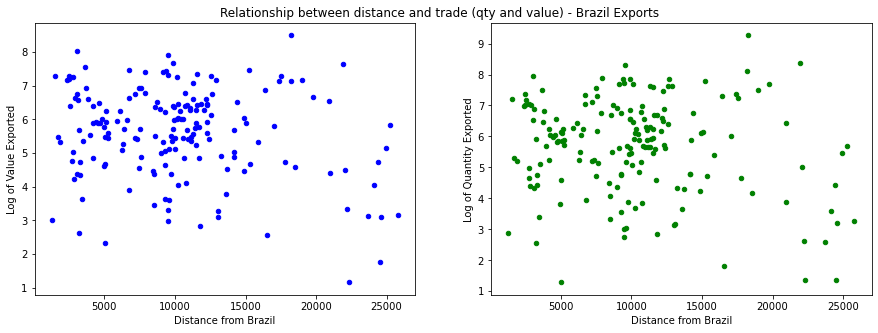

In [49]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
ax1 = b_sum.plot.scatter(x= "BR_dist",
                      y= "log_v",
                      c='Blue',
                      ax=ax1)
ax1.set_xlabel("Distance from Brazil")
ax1.set_ylabel("Log of Value Exported")

ax2 = b_sum.plot.scatter(x= "BR_dist",
                      y= "log_qty",
                      c='Green',
                      ax=ax2)
ax2.set_xlabel("Distance from Brazil")
ax2.set_ylabel("Log of Quantity Exported")

fig.suptitle('Relationship between distance and trade (qty and value) - Brazil Exports', y=0.925)

In [24]:
b_countries.corr(method = "pearson")


,BR_dist,v,q,log_v,log_q
BR_dist,1.000000,0.060216,0.128321,-0.191059,-0.161758
v,0.060216,1.000000,0.932370,0.396280,0.391363
q,0.128321,0.932370,1.000000,0.258593,0.276992
log_v,-0.191059,0.396280,0.258593,1.000000,0.979834
log_q,-0.161758,0.391363,0.276992,0.979834,1.000000


### There is little correlation between value and distance. 